# Preparing Data

In [1]:
# Installing necessary libraries 
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install networkx
# !pip install powerlaw
# !pip install graphistry
# !pip install cpi
# !pip install nltk
# !pip install scipy

In [2]:
# Importing necessary libraries
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import powerlaw
import seaborn as sns
import graphistry
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from scipy import stats
from networkx.algorithms import community



nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\musti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\musti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data & initialize graph nodes

The following code block loads the Boxofficemojo dataset, removes movies where there is no worldwide box office data, convert runtime to integers, converts release date to "xx-xx-xxxx" format and initializes the graph nodes  

In [3]:
movies = pd.read_csv(r'data\Kaggle\Mojo_budget_update.csv\Mojo_budget_update.csv')
# remove a column mpaa
movies = movies.drop(columns=['mpaa'])
# remove rows with nan in worldwide and in budget
movies = movies.dropna(subset=["worldwide"])
# movies = movies.dropna(subset=["budget"])
# fill nan with unknown
movies = movies.fillna("UNKNOWN",)
# number of nan in each column 
# {'mpaa': 161, 'release_date': 1, 'distributor': 15, 'writer': 9, 'producer': 13, 'composer': 105, 'cinematographer': 114, 
# 'main_actor_4': 3, 'domestic': 19, 'international': 410, 'worldwide': 7, 'genre_2': 281, 'genre_3': 1022, 'genre_4': 2120}

#Make a graph
movie_graph = nx.Graph()
movie_graph.add_nodes_from(movies['title'])
# reformat the date
def getDate(year,date):
    dict_months = {'January':"1", 'February':"2", 'March':"3", 'April':"4", 'May':"5", 'June':"6", 'July':"7", 'August':"8", 'September':"9", 'October':"10", 'November':"11", 'December':"12"}
    try:
        date = date.split()
    except:
        date = ['January','1']
    year = str(year)
    date = str(date[1]) + '-' + dict_months[date[0]] + '-' + year
    return date
# reformat the run time
def getRunTime(run_time):
    try:
        run_time = run_time.split()
        run_time = int(run_time[0]) * 60 + int(run_time[2])
    except:
        run_time = "UNKNOWN"
    return run_time

# add attributes to the nodes#mpaa is after the release year
for node in movie_graph.nodes:
    row = movies.loc[movies['title'] == node]
    movie_id, _,release_year,_,release_date, run_time, distributor, director, writer, producer, composer, cinematographer, \
    main_actor_1, main_actor_2, main_actor_3, main_actor_4, budget, domestic, international, worldwide, \
    genre_1, genre_2, genre_3, genre_4, link = row.iloc[0, :].values

    release_date = getDate(release_year, release_date)
    run_time = getRunTime(run_time)
    actors = [main_actor_1, main_actor_2, main_actor_3, main_actor_4]
    genres = [genre_1, genre_2, genre_3, genre_4]
    
    movie_graph.nodes[node]['movie_id'] = movie_id
    movie_graph.nodes[node]['release_year'] = release_year
    movie_graph.nodes[node]['release_date'] = release_date
    movie_graph.nodes[node]['run_time'] = run_time
    movie_graph.nodes[node]['distributor'] = distributor
    movie_graph.nodes[node]['director'] = director
    movie_graph.nodes[node]['writer'] = writer
    movie_graph.nodes[node]['producer'] = producer
    movie_graph.nodes[node]['composer'] = composer
    movie_graph.nodes[node]['cinematographer'] = cinematographer
    movie_graph.nodes[node]['actors'] = actors
    movie_graph.nodes[node]['budget'] = budget
    movie_graph.nodes[node]['domestic'] = domestic
    movie_graph.nodes[node]['international'] = international
    movie_graph.nodes[node]['worldwide'] = worldwide
    movie_graph.nodes[node]['genres'] = genres
    movie_graph.nodes[node]['link'] = link


In [4]:
print("Number of nodes", len(movie_graph.nodes)) 
print("Number of unique distributor", len(movies["distributor"].unique()))
# print("precentag of movies per distributor" , movies["distributor"].value_counts())
print(f"Budget Stats \n mean is {round(movies["budget"].mean())}, midian is {movies["budget"].median()}, standard deviation budget is { round(movies["budget"].std())}")
print(f"worldwide Stats \n mean is {round(movies["worldwide"].mean())}, midian is {movies['worldwide'].median()}, standard deviation worldwide is { round(movies['worldwide'].std())}")
print("Number of unique genres", len(movies["genre_1"].unique()))
print("Number of unique actors", len((movies["main_actor_1"]+movies["main_actor_2"]+movies["main_actor_3"]+movies["main_actor_4"]).unique()))
print(f"Number of unique directors {len(movies['director'].unique())} writers {len(movies['writer'].unique())} and producers {len(movies['producer'].unique())} and composers {len(movies['composer'].unique())} and cinematographers {len(movies['cinematographer'].unique())}")
print(f"Earnings Stats \n mean is {round(movies['worldwide'].mean())-round(movies['budget'].mean())}, midian is {movies['worldwide'].median()-movies['budget'].median()}")
print("biggest Winner is ", movies.loc[(movies['worldwide']-movies['budget']).idxmax()]['title'])
print("biggest Loser is ", movies.loc[(movies['worldwide']-movies['budget']).idxmin()]['title'])
# print("Movies released per year", movies['year'].value_counts(ascending=True))

Number of nodes 3208
Number of unique distributor 197
Budget Stats 
 mean is 46308759, midian is 30000000.0, standard deviation budget is 47097816
worldwide Stats 
 mean is 139312154, midian is 62251587.5, standard deviation worldwide is 216210703
Number of unique genres 15
Number of unique actors 3212
Number of unique directors 1520 writers 2103 and producers 1539 and composers 792 and cinematographers 854
Earnings Stats 
 mean is 93003395, midian is 32251587.5
biggest Winner is  Avatar
biggest Loser is  Mars Needs Moms


In [5]:
movies[movies['title'] == 'The Matrix']

,movie_id,title,year,trivia,release_date,run_time,distributor,director,writer,producer,...,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html
464,tt0133093,The Matrix,1999,A computer hacker learns from mysterious rebel...,March 31,2 hr 16 min,Warner Bros.,Lana Wachowski,Lilly Wachowski,Joel Silver,...,Hugo Weaving,63000000.0,171479930.0,293863857.0,465343787.0,Action,Sci-Fi,UNKNOWN,UNKNOWN,https://www.boxofficemojo.com/title/tt0133093/...


The following code block does:
* Reads the Rotten Tomatoes reviews dataset
* keeps the movie id, reviewid, and review text
* drop rows that holds no review text
* Reads the Rotten Tomatoes movies dataset (where it  holds information about the movies)
* Joins the 2 data sets into a `merged_reviews` data sets that now holds id, reviewId, reviewText and movie title

In [6]:
reviews = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movie_reviews.csv')
reviews_head = reviews.head()
reviews=reviews[["id","reviewId","reviewText"]]
reviews = reviews.dropna(subset=["reviewText"])
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')
RT_movies=RT_movies[["id","title","tomatoMeter"]]
merged_reviews = pd.merge(RT_movies, reviews, on='id')
merged_reviews = pd.merge(merged_reviews, movies[['title']], left_on='title', right_on='title')


In [7]:
print("number of movies with reviews", len(merged_reviews['title'].unique()))
print("number of reviews", len(merged_reviews['reviewId'].unique()))
print("number of reviews per movie", merged_reviews['title'].value_counts(ascending=False))
print(f"mean number of reviews per movie {merged_reviews['title'].value_counts().mean()} median {merged_reviews['title'].value_counts().median()}")
print("number of movies with more than 50 reviews", len(merged_reviews['title'].value_counts()[merged_reviews['title'].value_counts()>50]))
print(f"The mean length of reviews is {merged_reviews['reviewText'].apply(len).mean()} and the median is {merged_reviews['reviewText'].apply(len).median()}")
print(f"The mean number of words in reviews is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).mean()} and the median is {merged_reviews['reviewText'].apply(lambda x: len(x.split())).median()}")

number of movies with reviews 2932
number of reviews 413562
number of reviews per movie title
Parasite                1921
Beauty and the Beast    1168
The Lion King           1122
Godzilla                1084
Little Women            1038
                        ... 
The Lorax                  1
Royal Kill                 1
A Long Way Off             1
Beat the Drum              1
Alone Yet Not Alone        1
Name: count, Length: 2932, dtype: int64
mean number of reviews per movie 146.55388813096863 median 130.0
number of movies with more than 50 reviews 2448
The mean length of reviews is 127.99440301980935 and the median is 127.0
The mean number of words in reviews is 21.466581024724455 and the median is 21.0


### Add the reviews of the movies in nodes

In [8]:
dicReviews = {}
for index, row in merged_reviews.iterrows():
    if row['title'] in movie_graph.nodes:
        if row['title'] not in dicReviews:
            dicReviews[row['title']] = []
        dicReviews[row['title']].append(row['reviewText'])
print("Number of movies with reviews", len(dicReviews))
print("total number of reviews", len([j for i in dicReviews.values() for j in i]))

for node in movie_graph.nodes:
    if node in dicReviews:
        movie_graph.nodes[node]['reviews'] = dicReviews[node]
        movie_graph.nodes[node]['tomatoMeter'] =merged_reviews.loc[merged_reviews['title'] == node]['tomatoMeter'].values[0] 

Number of movies with reviews 2932
total number of reviews 429696


In [9]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 3208


### Remove movies with no reviews

In [10]:
nodes_to_remove = []
# Find nodes without the "reviews" attributes
for node in movie_graph.nodes:
    if movie_graph.nodes[node].get("reviews") is None:
        nodes_to_remove.append(node)

# Remove those nodes from the graph
movie_graph.remove_nodes_from(nodes_to_remove)

In [11]:
print("Number of nodes", len(movie_graph.nodes)) 

Number of nodes 2932


### Adjust the monetary values for inflation

In [12]:
import cpi
##  budget domestic  international worldwide 
for node in movie_graph.nodes:
    movie_graph.nodes[node]['budget'] = cpi.inflate(int(movie_graph.nodes[node]['budget']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['domestic'] != "UNKNOWN":
        movie_graph.nodes[node]['domestic'] = cpi.inflate(int(movie_graph.nodes[node]['domestic']), movie_graph.nodes[node]['release_year'])
    if movie_graph.nodes[node]['international'] != "UNKNOWN":
        movie_graph.nodes[node]['international'] = cpi.inflate(int(movie_graph.nodes[node]['international']), movie_graph.nodes[node]['release_year'])
    movie_graph.nodes[node]['profit'] = movie_graph.nodes[node]['worldwide'] - movie_graph.nodes[node]['budget']

c:\Users\musti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


### Calculate the sentiment of nodes

In [13]:
# Create an instance of the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# get sentiment for each review in each node
for node in movie_graph.nodes:
    reviews = movie_graph.nodes[node]['reviews']

    sentiments_per_review = [analyzer.polarity_scores(review) for review in reviews]
    
    # movie's sentiment based on all reviews (mean compound score)          
    compound_sentiments = [sentiment_scores["compound"] for sentiment_scores in sentiments_per_review]
    movie_sentiment = np.mean(compound_sentiments) if compound_sentiments else 0.0
    
    # Assign the aggregated sentiment to the node
    movie_graph.nodes[node]['mean_compound_sentiment'] = movie_sentiment
    movie_graph.nodes[node]['sentiments_per_review'] = sentiments_per_review

In [14]:
movie_graph.nodes["Die Hard 2"]

{'movie_id': 'tt0099423',
 'release_year': np.int64(1990),
 'release_date': '6-7-1990',
 'run_time': 124,
 'distributor': 'Twentieth Century Fox',
 'director': 'Renny Harlin',
 'writer': 'Walter Wager',
 'producer': 'Charles Gordon',
 'composer': 'Michael Kamen',
 'cinematographer': 'Oliver Wood',
 'actors': ['Bruce Willis',
  'William Atherton',
  'Bonnie Bedelia',
  'Reginald VelJohnson'],
 'budget': 145125478.19433823,
 'domestic': 243688373.43986234,
 'international': 254397677.9756695,
 'worldwide': np.float64(240247433.0),
 'genres': ['Action', 'Thriller', 'UNKNOWN', 'UNKNOWN'],
 'link': 'https://www.boxofficemojo.com/title/tt0099423/credits/',
 'reviews': ['Plays it very safe with the plot by copying a lot of what made the first work but sadly the villains of the piece are far&#44; far less interesting&#46; It does have some fun scenes and Bruce Willis is still on fine form so still worth a watch though&#46;&#46;&#46;',
  'Die Hard 2 is ubiquitous and sensationally entertaining.

In [15]:
for node in list(movie_graph.nodes)[:5]:
    print(node)
    print(movie_graph.nodes[node]["mean_compound_sentiment"], "\n")
    print(movie_graph.nodes[node]["tomatoMeter"], "\n")


Back to the Future Part III
0.4589757575757576 

80.0 

The Bonfire of the Vanities
-0.07092222222222222 

15.0 

Dick Tracy
0.1416142857142857 

nan 

Die Hard 2
0.10247884615384614 

70.0 

Flight of the Intruder
0.02735 

25.0 



In [16]:
RT_movies = pd.read_csv(r'data\Kaggle\Rotten_Tomatoes\rotten_tomatoes_movies.csv')

# Print the column names to verify
print(RT_movies.columns)

Index(['id', 'title', 'audienceScore', 'tomatoMeter', 'rating',
       'ratingContents', 'releaseDateTheaters', 'releaseDateStreaming',
       'runtimeMinutes', 'genre', 'originalLanguage', 'director', 'writer',
       'boxOffice', 'distributor', 'soundMix'],
      dtype='object')


#### Bayesian Adjustment of movie sentiments

In this analysis, we apply **Bayesian adjustment** to refine the sentiment of each movie based on its review count and the global sentiment of all movies in the network.

The basic idea is to adjust each movie's sentiment by **shrinking** it toward the **global sentiment (Prior)**, especially for movies with fewer reviews, which may have more uncertainty in their sentiment values. This way, movies with fewer reviews are "regularized" and their sentiment is adjusted closer to the overall trend of the movie network.

The formula for Bayesian adjustment is:

$$
\text{Adjusted Sentiment}_i = \frac{(n_i \cdot \text{mean\_sentiment}_i) + (m \cdot \text{Global Sentiment})}{n_i + m}
$$

Where:
- \( $ n_i $ \) is the number of reviews for movie \( $ i $ \),
- \( $ \text{mean\_sentiment}\_i $ \) is the mean sentiment of movie \( $ i $ \),
- \( $ m $ \) is a tuning parameter that controls the influence of the **Global Sentiment** (Prior),
- \( $ \text{Global Sentiment} $ \) is the average sentiment of all movies in the network.

This adjustment helps to reduce the influence of movies with fewer reviews and ensures that the global sentiment remains consistent even when a movie has only a few data points.


##### PRIOR (Global sentiment) based on the unadjusted sentiments


In [ ]:
# Calculate the Global Sentiment (Prior) as the mean of the mean_compound_sentiment values
def calculate_global_sentiment(G):
    total_sentiment = 0
    num_movies = len(G.nodes)
    
    for node in G.nodes:
        total_sentiment += G.nodes[node]["mean_compound_sentiment"]
    
    global_sentiment = total_sentiment / num_movies
    return global_sentiment

# Calculate the initial Global Sentiment (Prior)
global_sentiment = calculate_global_sentiment(movie_graph)
print(global_sentiment)

0.17876725900853307


##### Adjustment of the sentiments

In [ ]:
# Apply Bayesian Adjustment for each movie using the Prior
def apply_bayesian_adjustment(G, global_sentiment, m=5):
    for node in G.nodes:
        num_reviews = len(G.nodes[node]["reviews"])  
        mean_sentiment = G.nodes[node]["mean_compound_sentiment"]
        
        # Apply Bayesian adjustment
        adjusted_sentiment = (num_reviews * mean_sentiment + m * global_sentiment) / (num_reviews + m)
        
        # Update the node with the adjusted sentiment
        G.nodes[node]["adjusted_sentiment"] = adjusted_sentiment


apply_bayesian_adjustment(movie_graph, global_sentiment)

##### PRIOR (Global sentiment) after the adjustment of sentiments

In [ ]:
# Recalculate the Global Sentiment (Prior) based on the adjusted sentiments
def recalculate_global_sentiment(G):
    total_sentiment = 0
    num_movies = len(G.nodes)
    
    # Sum of all adjusted sentiments
    for node in G.nodes:
        total_sentiment += G.nodes[node]["adjusted_sentiment"]
    
    adjusted_global_sentiment = total_sentiment / num_movies
    return adjusted_global_sentiment

# Recalculate the Global Sentiment after adjustment
adjusted_global_sentiment = recalculate_global_sentiment(movie_graph)

##### BAYESIAN ADJUSTMENT OVERVIEW

In [ ]:
print("GLOBAL SENTIMENT (PRIOR):")
print(f"NOT adjusted: {global_sentiment:.5f}")
print(f"Adjusted: {adjusted_global_sentiment:.5f}\n\n")

print("MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:\n")
# Print the adjusted sentiments for each movie
for node in list(movie_graph.nodes)[:10]:
    print(f"{node}")
    print(f"NOT adjusted Sentiment = {movie_graph.nodes[node]['mean_compound_sentiment']:.5f}")
    print(f"Adjusted Sentiment = {movie_graph.nodes[node]['adjusted_sentiment']:.5f}\n")

GLOBAL SENTIMENT (PRIOR):
NOT adjusted: 0.17877
Adjusted: 0.18035


MOVIE SENTIMENTS ADJUSTMENTS EXAMPLES:

Back to the Future Part III
NOT adjusted Sentiment = 0.45898
Adjusted Sentiment = 0.42211

The Bonfire of the Vanities
NOT adjusted Sentiment = -0.07092
Adjusted Sentiment = -0.04047

Dick Tracy
NOT adjusted Sentiment = 0.14161
Adjusted Sentiment = 0.14557

Die Hard 2
NOT adjusted Sentiment = 0.10248
Adjusted Sentiment = 0.10917

Flight of the Intruder
NOT adjusted Sentiment = 0.02735
Adjusted Sentiment = 0.11147

Frankenhooker
NOT adjusted Sentiment = 0.46939
Adjusted Sentiment = 0.37252

Ghost
NOT adjusted Sentiment = 0.31888
Adjusted Sentiment = 0.30928

Havana
NOT adjusted Sentiment = 0.09689
Adjusted Sentiment = 0.11638

Home Alone
NOT adjusted Sentiment = 0.35955
Adjusted Sentiment = 0.34147

The Hunt for Red October
NOT adjusted Sentiment = 0.29741
Adjusted Sentiment = 0.28829



### Add edges to the graph 
based on actors, if to movies share at least one actor there will be edge between them. 

In [17]:
# list of movies for each actor
actor_to_movies = defaultdict(set)

for movie in movie_graph.nodes:
    actors = movie_graph.nodes[movie].get('actors', [])
    for actor in actors:
        if actor != "UNKNOWN":
            actor_to_movies[actor].add(movie)


In [18]:
# Add edges between movies that share an actor
for actor, movies in actor_to_movies.items():
    movie_list = list(movies)
    for i in range(len(movie_list)):
        for j in range(i + 1, len(movie_list)):
            movie_graph.add_edge(movie_list[i], movie_list[j], actor=actor, weight=len(actor_to_movies[actor]))

In [19]:
print(f"Number of nodes: {movie_graph.number_of_nodes()}")
print(f"Number of edges: {movie_graph.number_of_edges()}")

Number of nodes: 2932
Number of edges: 37774


### Delete isolated nodes

In [20]:
# Remove isolated nodes
isolated_nodes = [node for node, degree in dict(movie_graph.degree()).items() if degree == 0]

graph_no_isolated = movie_graph.copy()
graph_no_isolated.remove_nodes_from(isolated_nodes)

In [21]:
print(f"Number of nodes in main graph: {movie_graph.number_of_nodes()}")
print(f"Number of edges in main graph: {movie_graph.number_of_edges()}")

print(f"\nNumber of nodes without isolated: {graph_no_isolated.number_of_nodes()}")
print(f"Number of edges without isolated: {graph_no_isolated.number_of_edges()}")

Number of nodes in main graph: 2932
Number of edges in main graph: 37774

Number of nodes without isolated: 2799
Number of edges without isolated: 37774


### Extract the largest component

In [22]:
# Extract the largest connected component
largest_component = max(nx.connected_components(graph_no_isolated), key=len)
graph_largest = graph_no_isolated.subgraph(largest_component).copy()

print(f"Number of nodes in largest_component: {graph_largest.number_of_nodes()}")
print(f"Number of edges in largest_component: {graph_largest.number_of_edges()}")

Number of nodes in largest_component: 2777
Number of edges in largest_component: 37758


## Degree distribution

In [23]:
# Get degree distribution
degree_sequence = sorted([d for n, d in movie_graph.degree()], reverse=True)  # Sorted list of degrees
degree_count = np.bincount(degree_sequence)  # Count occurrences of each degree
degrees = np.arange(len(degree_count)) 

# Check for hubs in the network
max_degree = max(degree_sequence)
average_degree = np.mean(degree_sequence)
print("Maximum degree:", max_degree)
print("Average degree:", average_degree)

Maximum degree: 91
Average degree: 25.766712141882675


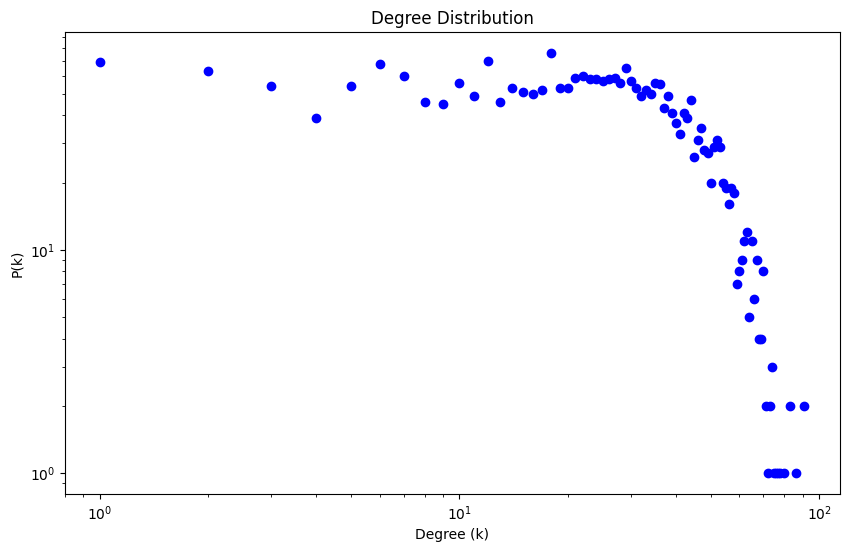

In [24]:
# Plot the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees[degrees > 0], degree_count[degrees > 0], 'bo')  # Exclude zero degree entries
plt.xlabel("Degree (k)")
plt.ylabel("P(k)")
plt.title("Degree Distribution")
plt.show()

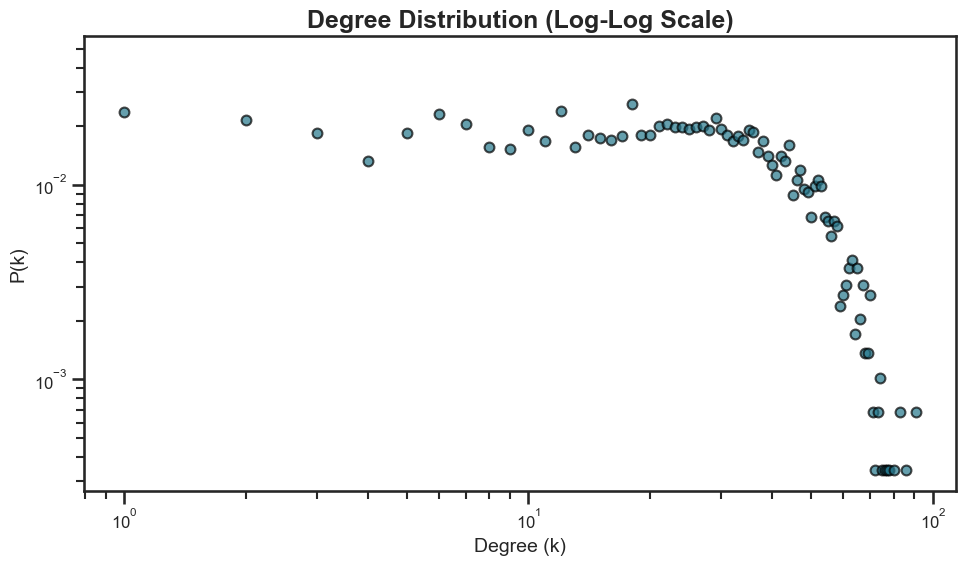

In [25]:
def plot_log_log_degree_dist(
    G, 
    filename="log_log_degree_distribution.png", 
    ref_alpha=None, 
    ref_xmin=None
):
    # Extract degrees of nodes
    degrees = [G.degree(n) for n in G.nodes()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    
    # Compute P(k) = counts / total number of nodes
    pk = counts / len(degrees)
    
    # Set up Seaborn style
    sns.set(style="ticks", context="talk")  # Use "ticks" style for minimal grid
    palette = sns.color_palette("crest", as_cmap=True)  # New colormap
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for P(k) vs k
    plt.scatter(
        unique_degrees, 
        pk, 
        color=palette(0.6),  # Pick a distinct color
        alpha=0.7, 
        s=50, 
        edgecolor="black", 
        label="Observed P(k)"
    )
    
    # Add a reference power-law line if specified
    if ref_alpha is not None and ref_xmin is not None:
        x_ref = np.array(sorted(unique_degrees[unique_degrees >= ref_xmin]))
        y_ref = (x_ref ** (-ref_alpha)) / np.sum(x_ref ** (-ref_alpha))
        plt.plot(
            x_ref, y_ref, 
            linestyle="--", color="red", linewidth=2, 
            label=f"Power-law fit (α={ref_alpha:.2f}, xmin={ref_xmin})"
        )
    
    # Add title and labels
    plt.title("Degree Distribution (Log-Log Scale)", fontsize=18, weight='bold')
    plt.xlabel("Degree (k)", fontsize=14)
    plt.ylabel("P(k)", fontsize=14)
    
    # Log-log scale
    plt.xscale("log")
    plt.yscale("log")
    
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot to a file
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')  # Save with high resolution
    
    # Show the plot
    plt.show()

plot_log_log_degree_dist(movie_graph)

## Is our network scale-free?

In [26]:
# Fit the degree sequence to a power law
fit = powerlaw.Fit(degree_sequence)

# Check the power law exponent
print("Power law alpha:", fit.power_law.alpha)
print("xmin for power law fit:", fit.power_law.xmin)

# Compare power-law fit with other distributions
R, p = fit.distribution_compare('power_law', 'exponential')
print("Likelihood ratio R:", R)
print("p-value:", p)

# Interpretation: 
# - If R > 0 and p < 0.05, the power-law fit is significantly better than the exponential fit, 
#   suggesting the network is likely scale-free.

Calculating best minimal value for power law fit
Power law alpha: 14.108294576605937
xmin for power law fit: 65.0
Likelihood ratio R: 0.538158801531007
p-value: 0.2599068976144647


Values less than or equal to 0 in data. Throwing out 0 or negative values


## Plot the base network

In [27]:
# # Calculate node sizes based on degree
# node_sizes = [100 + 20 * movie_graph.degree(node) for node in movie_graph.nodes]

# plt.figure(figsize=(12, 12))
# pos = nx.spring_layout(movie_graph, seed=42)

# # Draw nodes with varying size
# nx.draw_networkx_nodes(movie_graph, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# # Draw edges
# nx.draw_networkx_edges(movie_graph, pos, width=0.5, alpha=0.5)

# plt.title("Movie Network Visualization with Adjusted Spacing")
# plt.axis("off")
# plt.show()


## Plot the extracted largest component

In [28]:
# # Calculate node sizes based on degree in the subgraph
# node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

# plt.figure(figsize=(10, 10))
# pos = nx.spring_layout(graph_largest, seed=42)

# # Draw nodes with varying size
# nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")

# # Draw edges
# nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# plt.title("Largest Connected Component of the Movie Network")
# plt.axis("off")
# plt.show()


### Kamada layout   

In [ ]:
# # Use Kamada-Kawai layout instead
# pos = nx.kamada_kawai_layout(graph_largest)

# nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color="skyblue", alpha=0.7, edgecolors="gray")
# nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)
# plt.title("Movie Network Visualization with Kamada-Kawai Layout")
# plt.axis("off")
# plt.show()


KeyboardInterrupt: 

### Network Visualisation

In [ ]:
# initial_pos = {n: np.random.rand(2) for n in movie_graph.nodes}
# pos = nx.spring_layout(movie_graph, k=2.0, iterations=50, pos=initial_pos)

# # Node DataFrame, including 'actors' attribute
# nodes_df = pd.DataFrame.from_dict(dict(movie_graph.nodes(data=True)), orient='index')
# nodes_df['degree'] = [movie_graph.degree[node] for node in movie_graph.nodes]
# nodes_df['x'] = [pos[node][0] for node in movie_graph.nodes]
# nodes_df['y'] =  [pos[node][1] for node in movie_graph.nodes]

# # Edge DataFrame
# edges_df = nx.to_pandas_edgelist(movie_graph)
# edges_df['source'] = edges_df['source'].astype(str)
# edges_df['target'] = edges_df['target'].astype(str)

# # Make the plot in the visualisation undirected
# edges_df['edge'] = edges_df.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)
# undirected_edges_df = edges_df.drop_duplicates(subset='edge').drop(columns='edge').reset_index(drop=True)

# # Replace non-numeric values with NaN and convert column to numeric
# nodes_df['domestic'] = pd.to_numeric(nodes_df['domestic'], errors='coerce')
# nodes_df['international'] = pd.to_numeric(nodes_df['international'], errors='coerce')
# nodes_df["run_time"] = pd.to_numeric(nodes_df["run_time"], errors='coerce')

In [ ]:
# # Bind the nodes and edges to Graphistry, specifying the source, destination, and node key
# # Set up Graphistry (replace with your credentials or use environment variables)
# graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="michalis", password="FDKeHQR4EQg7pvb")

# graph = graphistry.bind(source="source", destination="target", point_x="x", point_y="y") \
#                  .edges(undirected_edges_df) \
#                  .nodes(nodes_df.reset_index(), node="index") \
#                  .encode_point_size("degree") 

# graph.plot()

## Plots based on sentiment

### Node Sizes and Colors Based on Mean Compound Sentiment (Red to Green)

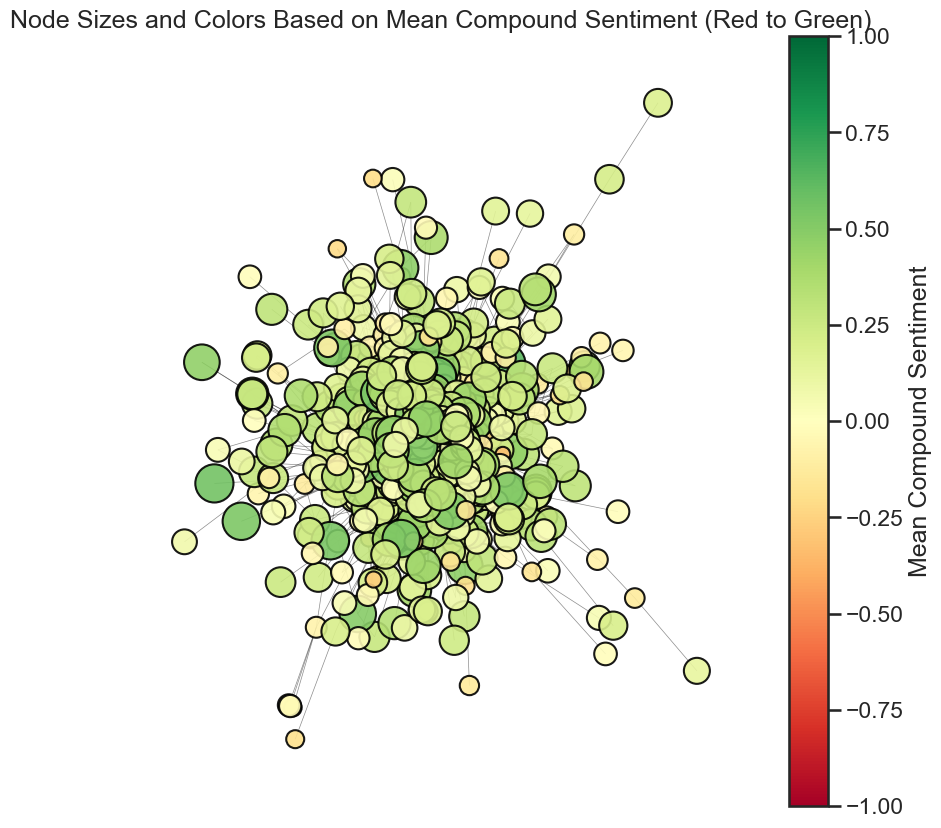

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Extract sentiment values
sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Normalize sentiment values to a range (100 to 2000) with exponential scaling
min_size, max_size = 50, 1000
min_sent, max_sent = min(sentiments), max(sentiments)
node_sizes = [
    min_size + (max_size - min_size) * ((sent - min_sent) / (max_sent - min_sent))**2 if max_sent > min_sent else min_size
    for sent in sentiments
]

norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size and color
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes and Colors Based on Mean Compound Sentiment (Red to Green)")
plt.axis("off")
plt.show()


### Node Sizes by Degree and Colors by Sentiment (Red to Green)

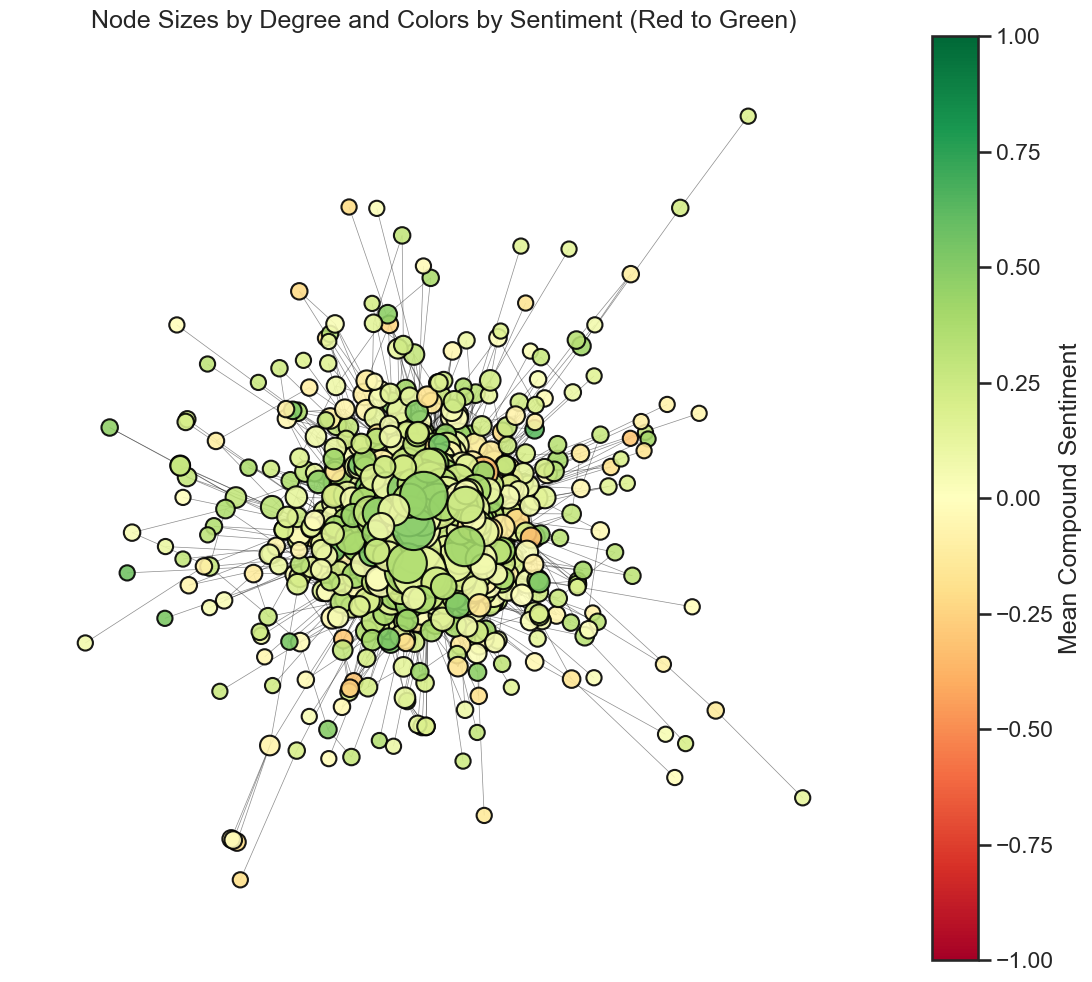

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Calculate node sizes based on degree in the subgraph
node_sizes = [100 + 20 * graph_largest.degree(node) for node in graph_largest.nodes]

# Extract sentiment values
sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Map sentiment values to a Red-to-Green color gradient
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn

# Create a ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(14, 12))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size (degree) and color (sentiment)
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=node_sizes, node_color=colors, alpha=0.9, edgecolors="black")

nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes by Degree and Colors by Sentiment (Red to Green)")
plt.axis("off")
plt.show()


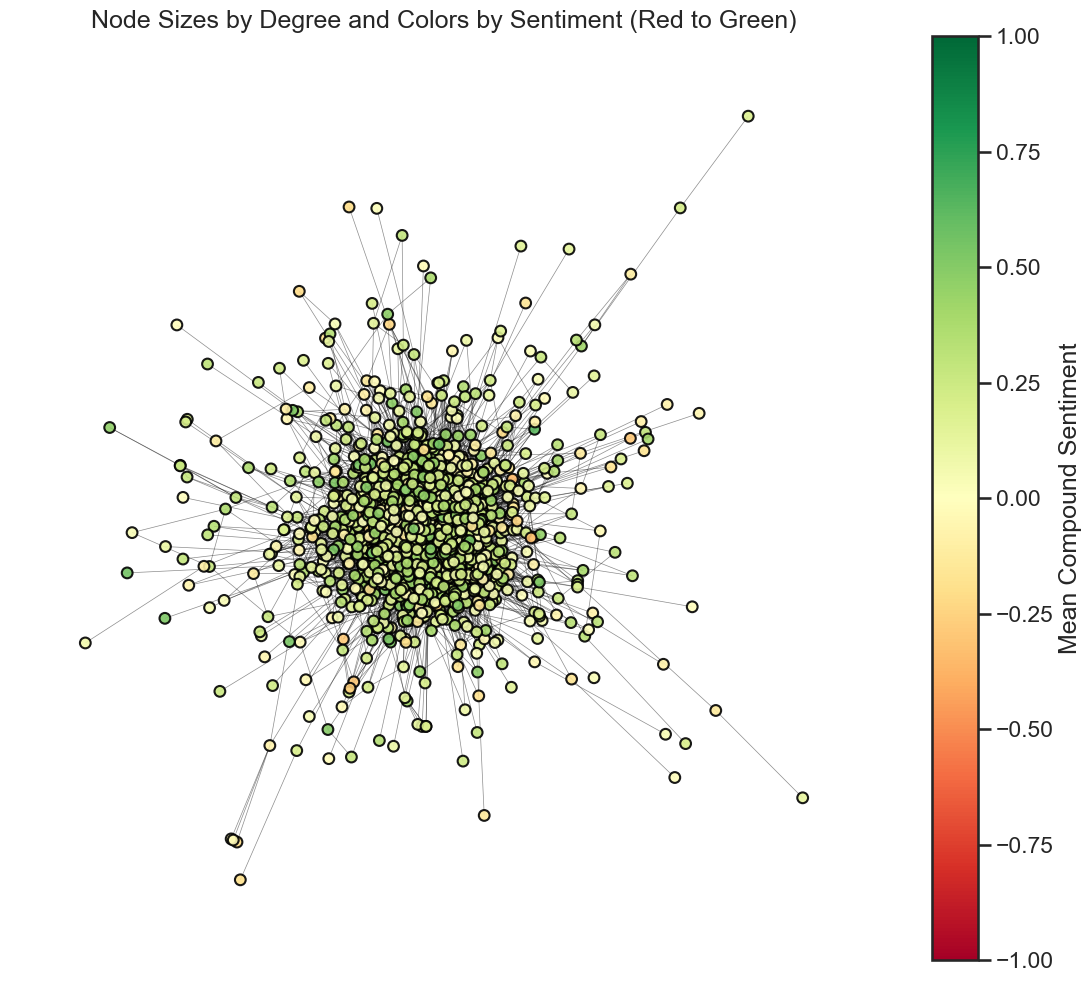

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Extract sentiment values
sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in graph_largest.nodes]

# Map sentiment values to a Red-to-Green color gradient
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Normalize between -1 and 1
cmap = cm.RdYlGn  # Red to Yellow to Green colormap

# Create a ScalarMappable for the colormap
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Associate it with an empty array for the colorbar

# Plot the graph
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(graph_largest, seed=42)

# Draw nodes with varying size (degree) and color (sentiment)
colors = [cmap(norm(sent)) for sent in sentiments]
nx.draw_networkx_nodes(graph_largest, pos, node_size=60, node_color=colors, alpha=0.9, edgecolors="black")

# Draw edges
nx.draw_networkx_edges(graph_largest, pos, width=0.5, alpha=0.5)

# Add the colorbar
cbar = plt.colorbar(sm, ax=plt.gca())  # Explicitly associate the colorbar with the current axis
cbar.set_label("Mean Compound Sentiment")

plt.title("Node Sizes by Degree and Colors by Sentiment (Red to Green)")
plt.axis("off")
plt.show()


### Distribution of Mean Compound Sentiment

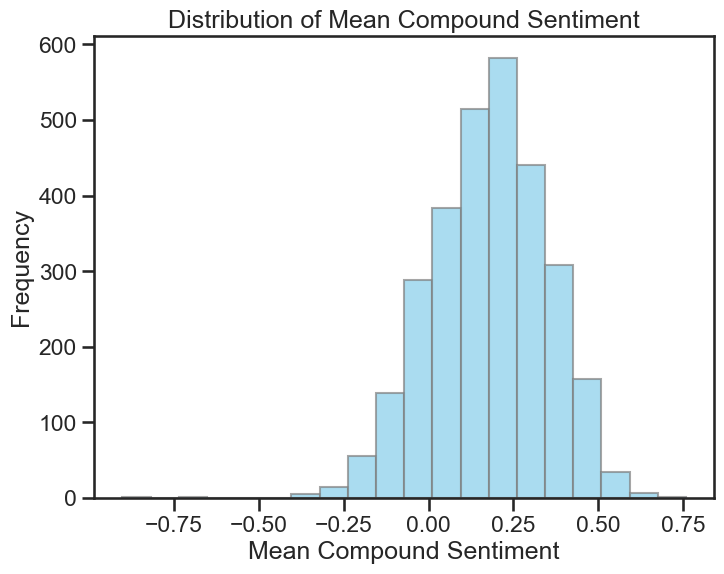

In [ ]:
import matplotlib.pyplot as plt

# Extract mean compound sentiment values
sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in movie_graph.nodes]

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(sentiments, bins=20, color='skyblue', edgecolor='gray', alpha=0.7)
plt.title("Distribution of Mean Compound Sentiment")
plt.xlabel("Mean Compound Sentiment")
plt.ylabel("Frequency")
plt.show()


### Node Degree vs. Mean Compound Sentiment

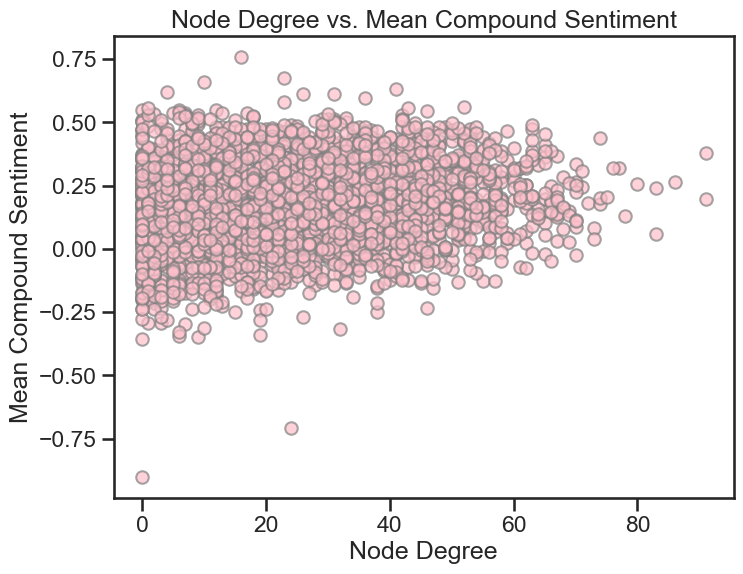

In [ ]:
# Extract degrees and sentiment scores
degrees = [movie_graph.degree(node) for node in movie_graph.nodes]
sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in movie_graph.nodes]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(degrees, sentiments, alpha=0.7, color='pink', edgecolor='gray')
plt.title("Node Degree vs. Mean Compound Sentiment")
plt.xlabel("Node Degree")
plt.ylabel("Mean Compound Sentiment")
plt.show()


### Average Sentiment Over Time

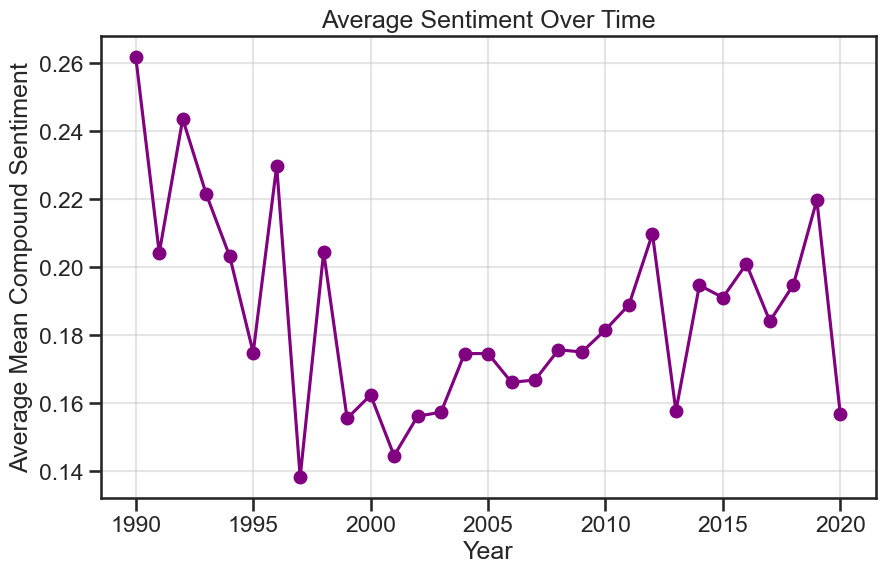

In [ ]:
# Group sentiment by release year
import pandas as pd

years = [movie_graph.nodes[node]['release_year'] for node in movie_graph.nodes]
data = pd.DataFrame({'year': years, 'sentiment': sentiments})

# Calculate average sentiment per year
avg_sentiment_per_year = data.groupby('year')['sentiment'].mean()

# Line plot
plt.figure(figsize=(10, 6))
avg_sentiment_per_year.plot(color='purple', marker='o')
plt.title("Average Sentiment Over Time")
plt.xlabel("Year")
plt.ylabel("Average Mean Compound Sentiment")
plt.grid(alpha=0.5)
plt.show()


### Top 10 Positive and Negative Sentiment Nodes - before sentiment adjustment

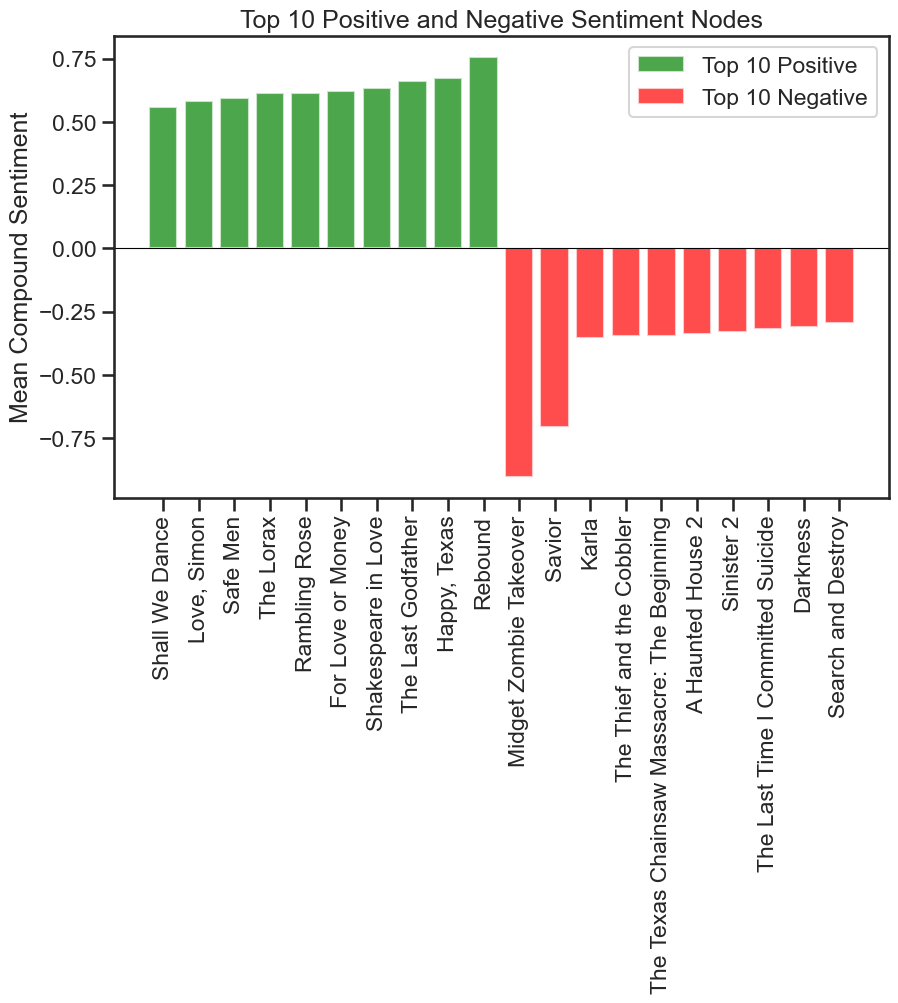

In [ ]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(movie_graph.nodes, key=lambda node: movie_graph.nodes[node]['mean_compound_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in top_10]
bottom_sentiments = [movie_graph.nodes[node]['mean_compound_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


### Top 10 Positive and Negative Sentiment Nodes - after sentiment adjustment

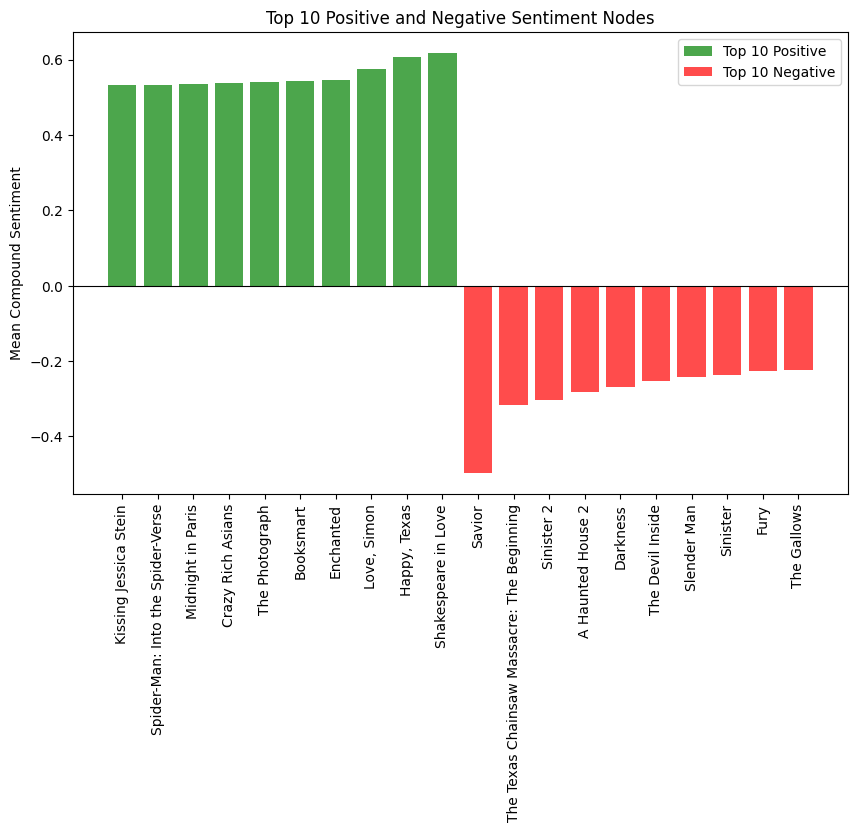

In [ ]:
# Get top/bottom sentiment nodes
sorted_nodes = sorted(movie_graph.nodes, key=lambda node: movie_graph.nodes[node]['adjusted_sentiment'])
top_10 = sorted_nodes[-10:]
bottom_10 = sorted_nodes[:10]

# Data for plotting
top_sentiments = [movie_graph.nodes[node]['adjusted_sentiment'] for node in top_10]
bottom_sentiments = [movie_graph.nodes[node]['adjusted_sentiment'] for node in bottom_10]

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(10), top_sentiments, color='green', alpha=0.7, label="Top 10 Positive")
plt.bar(range(10, 20), bottom_sentiments, color='red', alpha=0.7, label="Top 10 Negative")
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(range(20), labels=[*top_10, *bottom_10], rotation=90)
plt.title("Top 10 Positive and Negative Sentiment Nodes")
plt.ylabel("Mean Compound Sentiment")
plt.legend()
plt.show()


## Stats


Pearson correlation: 0.127 (p-value: 0.000)
Spearman correlation: 0.272 (p-value: 0.000)
Linear regression: slope=1378223.856, intercept=71505721.680, r=0.574, p=0.001, std_err=364655.606
t-test: t=-31.773, p=0.000
Welch's t-test: t=-31.773, p=0.000
T-test for the dict where it shows the mean profit for each category of actor popularity
t-test: t=-23.507, p=0.000
Welch's t-test: t=-23.507, p=0.000


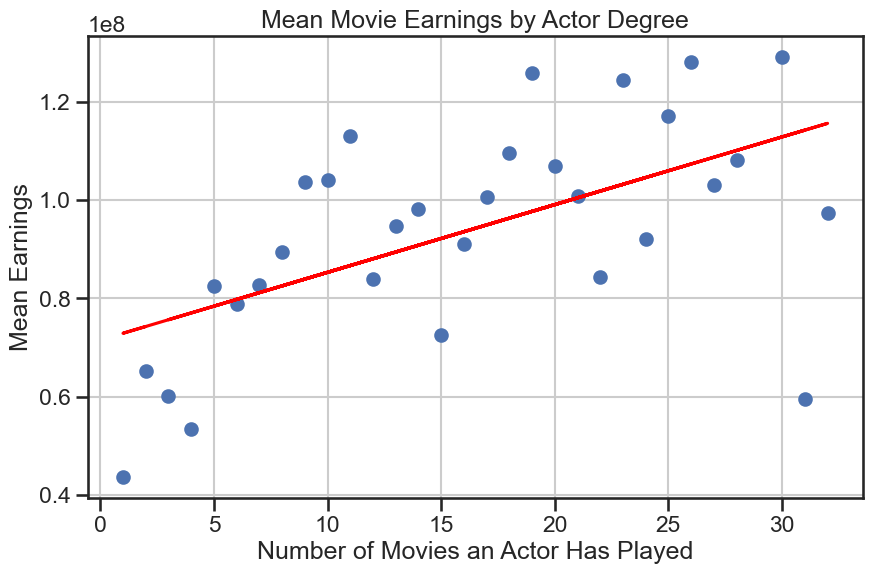

In [41]:
# make a dictionary with the actors and the number of movies they have played and the profit they have made
actor_degree = {actor: len(actor_to_movies[actor]) for actor in actor_to_movies.keys()} 
actor_avg_earning = {actor: np.mean([movie_graph.nodes[movie]['profit'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}
# make a list with the actors and the number of movies they have played and the profit they have made 
# The indices of the two lists correspond to the same actor
keys = sorted(set(actor_degree.keys()) | set(actor_avg_earning.keys()))
actor_degree_ls = [actor_degree.get(k) for k in keys]
actor_avg_earning_ls = [actor_avg_earning.get(k) for k in keys]
# Calculate Pearson and Spearman correlation
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_earning_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_earning_ls)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.3f})")

# calculate the mean profit for each "category" of actor popularity
# The try to colorate the 2
mean_by_degree = dict()
for degree, earning in zip(actor_degree_ls, actor_avg_earning_ls):
    if degree not in mean_by_degree:
        mean_by_degree.update({degree: [earning]})
    else:
        mean_by_degree[degree].append(earning)
mean_by_degree = {degree: np.mean(earnings) for degree, earnings in mean_by_degree.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree.keys()], [value for value in mean_by_degree.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")


# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(mean_by_degree.keys(), mean_by_degree.values())
plt.plot([key for key in mean_by_degree.keys()], [slope * key + intercept for key in mean_by_degree.keys()], color='red')  
plt.xlabel('Number of Movies an Actor Has Played')
plt.ylabel('Mean Earnings')
plt.title('Mean Movie Earnings by Actor Degree')
plt.grid(True)

# Perform t-tests
##Maybe does not make sense because they are not normally distributed
t_test = stats.ttest_ind(actor_degree_ls, actor_avg_earning_ls)
t_test_welch = stats.ttest_ind(actor_degree_ls, actor_avg_earning_ls, equal_var=False)

t_test_avg = stats.ttest_ind([key for key in mean_by_degree.keys()], [key for key in mean_by_degree.values()])
t_test_welch_avg = stats.ttest_ind([key for key in mean_by_degree.keys()], [key for key in mean_by_degree.values()])


print(f"t-test: t={t_test.statistic:.3f}, p={t_test.pvalue:.3f}")
print(f"Welch's t-test: t={t_test_welch.statistic:.3f}, p={t_test_welch.pvalue:.3f}")

print("T-test for the dict where it shows the mean profit for each category of actor popularity")
print(f"t-test: t={t_test_avg.statistic:.3f}, p={t_test_avg.pvalue:.3f}") 
print(f"Welch's t-test: t={t_test_welch_avg.statistic:.3f}, p={t_test_welch_avg.pvalue:.3f}")


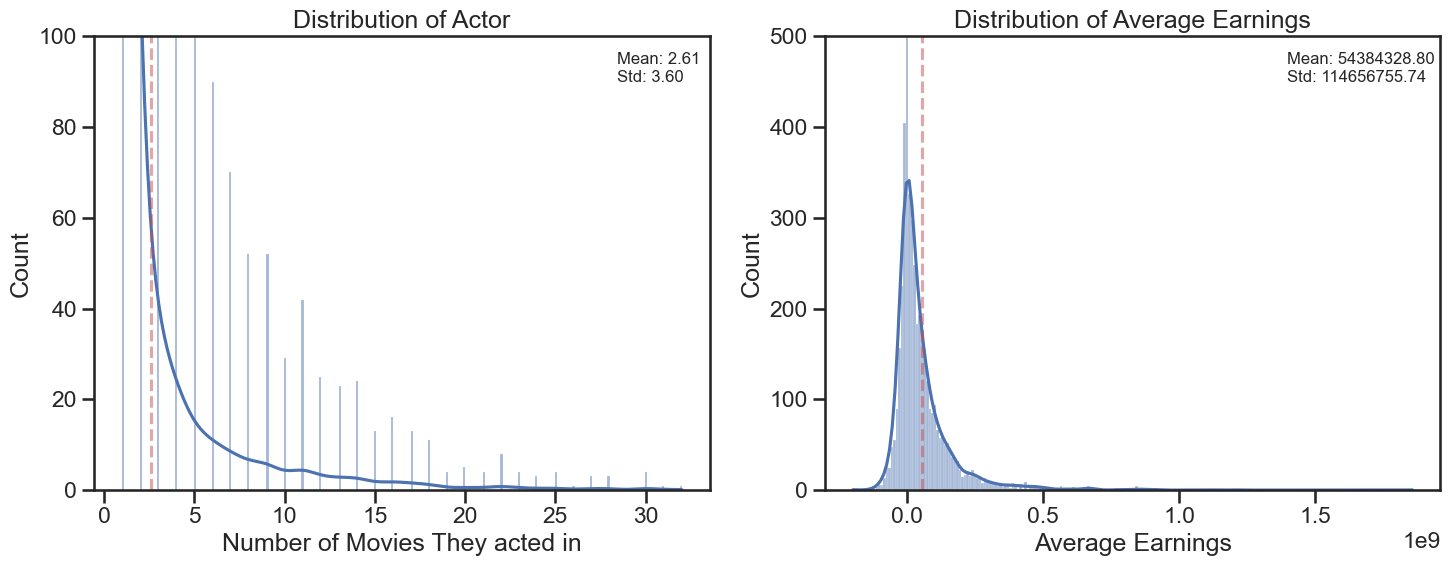

In [42]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Actor Degrees Distribution
sns.histplot(actor_degree_ls, kde=True, ax=ax1)
ax1.set_title('Distribution of Actor')
ax1.set_xlabel('Number of Movies They acted in')
ax1.set_ylabel('Count')
ax1.set_ylim(0, 100)

# Add mean and std annotations
mean_degree = np.mean(actor_degree_ls)
std_degree = np.std(actor_degree_ls)
ax1.axvline(mean_degree, color='r', linestyle='--', alpha=0.5)
ax1.text(0.85, 0.9, f'Mean: {mean_degree:.2f}\nStd: {std_degree:.2f}', 
         transform=ax1.transAxes, fontsize=12)

# Plot 2: Average Earnings Distribution
sns.histplot(actor_avg_earning_ls, kde=True, ax=ax2)
ax2.set_title('Distribution of Average Earnings')
ax2.set_xlabel('Average Earnings')
ax2.set_ylabel('Count')
ax2.set_ylim(0, 500)

# Add mean and std annotations
mean_earning = np.mean(actor_avg_earning_ls)
std_earning = np.std(actor_avg_earning_ls)
ax2.axvline(mean_earning, color='r', linestyle='--', alpha=0.5)
ax2.text(0.75, 0.90, f'Mean: {mean_earning:.2f}\nStd: {std_earning:.2f}', 
         transform=ax2.transAxes, fontsize=12)

plt.tight_layout()
plt.show()

In [43]:
# Measures Betweenness centrality measures how often a node acts as a bridge along the shortest path between two other nodes.
bet_cent = nx.betweenness_centrality(movie_graph)

# Measures Eigenvector centrality measures a node's importance based on the importance of its neighbors. 
# It assigns relative scores to all nodes in the network based on the principle that connections 
# to high-scoring nodes contribute more to the score of the node in question.

# High Eigenvector Centrality: Nodes with high scores are influential because they are connected to other influential nodes. 
# In a social network, these could be key influencers who are well-connected to other influencers.
eig_cent = nx.eigenvector_centrality(movie_graph)

# Degree centrality measures the proportion of direct connections a node has relative to the total possible connections
deg_cent = nx.degree_centrality(movie_graph)

# Edge betweenness centrality measures how often an edge is part of the shortest paths between pairs of nodes
edge_bet = nx.edge_betweenness_centrality(movie_graph)

KeyboardInterrupt: 

In [ ]:
top5Edges = sorted(edge_bet.items(), key=lambda x: x[1], reverse=True)[:5]
top5actors = []
for edge in top5Edges:
    movie1, movie2 = edge[0]
    for actor in movie_graph.nodes[movie1]['actors']:
        if actor in movie_graph.nodes[movie2]['actors']:
            top5actors.append(actor)

print("Top 5 actors with the highest betweenness centrality", top5actors)
print("Top 5 nodes with the highest betweenness centrality", sorted(bet_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 nodes with the highest eigenvector centrality", sorted(eig_cent.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 nodes with the highest degree centrality", sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5])

communities = community.greedy_modularity_communities(movie_graph)
modularity = community.modularity(movie_graph, communities)
print(f"Number of communities: {len(communities)}")
print(f"Modularity: {modularity:.3f}")

Top 5 actors with the highest betweenness centrality ['Ben Mendelsohn', 'Angus Macfadyen', 'James DeBello', 'Dean Cain', 'Tye Sheridan']
Top 5 nodes with the highest betweenness centrality [('Shark Tale', 0.0038470279010010848), ('Pain & Gain', 0.0036654541078375356), ('The Ant Bully', 0.003527101782866841), ('Captain Marvel', 0.0032750629522807057), ('Nurse Betty', 0.0029483748005372365)]
Top 5 nodes with the highest eigenvector centrality [("Ocean's Eleven", 0.09518826925347207), ('The Departed', 0.08485549079416646), ('Shark Tale', 0.07146445032379446), ("Ocean's Twelve", 0.07062313739210742), ('The Perfect Storm', 0.07005691462068141)]
Top 5 nodes with the highest degree centrality [("Ocean's Eleven", 0.031047424087342207), ('Shark Tale', 0.031047424087342207), ('The Ant Bully', 0.029341521664960766), ('Alexander', 0.028317980211531903), ('The Departed', 0.028317980211531903)]
Number of communities: 158
Modularity: 0.370


In [ ]:
slope, intercept, r, p, std_err = stats.linregress([cent for _,cent in eig_cent.items() ],[movie_graph.nodes[name]["profit"] for name,_ in eig_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")
slope, intercept, r, p, std_err = stats.linregress([cent for _,cent in deg_cent.items() ],[movie_graph.nodes[name]["profit"] for name,_ in deg_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")
slope, intercept, r, p, std_err = stats.linregress([cent for _,cent in bet_cent.items() ],[movie_graph.nodes[name]["profit"] for name,_ in bet_cent.items() ])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

Linear regression: slope=1640416940.725, intercept=53124721.993, r=0.124, p=0.000, std_err=242603926.494
Linear regression: slope=4620766700.794, intercept=33748050.011, r=0.158, p=0.000, std_err=532568013.883
Linear regression: slope=28051596870.007, intercept=56552980.932, r=0.098, p=0.000, std_err=5249711716.448


Pearson correlation: 0.069 (p-value: 0.0000)
Spearman correlation: 0.057 (p-value: 0.0002)
Linear regression: slope=0.003, intercept=0.155, r=0.069, p=0.000, std_err=0.001
Linear regression: slope=-0.000, intercept=0.189, r=-0.024, p=0.899, std_err=0.001


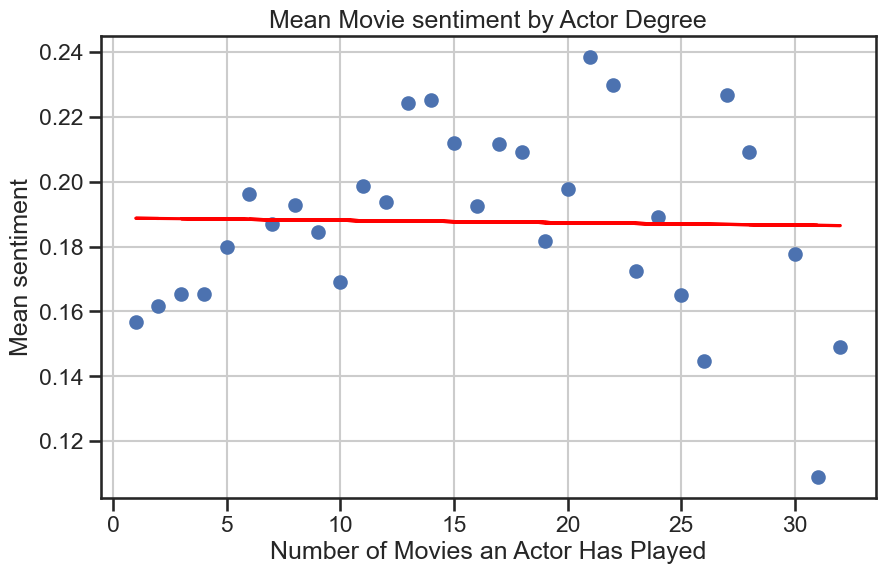

In [47]:
actor_avg_sentiment = {actor: np.mean([movie_graph.nodes[movie]['mean_compound_sentiment'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}
# make a list with the actors and the number of movies they have played and the profit they have made
# The indices of the two lists correspond to the same actor
keys = sorted(set(actor_degree.keys()) | set(actor_avg_sentiment.keys()))
actor_avg_sentiment_ls = [actor_avg_sentiment.get(k) for k in keys]

##correlation between the sentiment of the actor and the profit
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_sentiment_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_sentiment_ls)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.4f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")

slope, intercept, r, p, std_err = stats.linregress(actor_degree_ls,actor_avg_sentiment_ls)
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")


mean_by_degree_sen = dict()
for degree, sentiment in zip(actor_degree_ls, actor_avg_sentiment_ls):
    if degree not in mean_by_degree_sen:
        mean_by_degree_sen.update({degree: [sentiment]})
    else:
        mean_by_degree_sen[degree].append(sentiment)
mean_by_degree_sen = {degree: np.mean(earnings) for degree, earnings in mean_by_degree_sen.items()}

slope, intercept, r, p, std_err = stats.linregress([key for key in mean_by_degree_sen.keys()], [value for value in mean_by_degree_sen.values()])
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(mean_by_degree_sen.keys(), mean_by_degree_sen.values())
plt.plot([key for key in mean_by_degree_sen.keys()], [slope * key + intercept for key in mean_by_degree_sen.keys()], color='red')  
plt.xlabel('Number of Movies an Actor Has Played')
plt.ylabel('Mean sentiment')
plt.title('Mean Movie sentiment by Actor Degree')
plt.grid(True)

In [48]:
actor_avg_tomatoMeter = {actor: np.mean([movie_graph.nodes[movie]['tomatoMeter'] for movie in actor_to_movies[actor]]) for actor in actor_to_movies.keys()}
# make a list with the actors and the number of movies they have played and the profit they have made
# The indices of the two lists correspond to the same actor
keys = sorted(set(actor_degree.keys()) | set(actor_avg_tomatoMeter.keys()))
actor_avg_tomatoMeter_ls = [actor_avg_tomatoMeter.get(k) for k in keys]

##correlation between the sentiment of the actor and the profit
pearson_corr, pearson_p = stats.pearsonr(actor_degree_ls, actor_avg_tomatoMeter_ls)
spearman_corr, spearman_p = stats.spearmanr(actor_degree_ls, actor_avg_tomatoMeter_ls)

print(f"Pearson correlation: {pearson_corr:.3f} (p-value: {pearson_p:.4f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value: {spearman_p:.4f})")

slope, intercept, r, p, std_err = stats.linregress(actor_degree_ls,actor_avg_tomatoMeter_ls)
print(f"Linear regression: slope={slope:.3f}, intercept={intercept:.3f}, r={r:.3f}, p={p:.3f}, std_err={std_err:.3f}")


Pearson correlation: nan (p-value: nan)
Spearman correlation: nan (p-value: nan)
Linear regression: slope=nan, intercept=nan, r=nan, p=nan, std_err=nan
